In [1]:
from dgpsi import sexp_k_one_vector_derivative, gp, kernel, nb_seed, matern_k_one_vector_derivative, gp_pred
from mogp_emulator.ExperimentalDesign import LatinHypercubeDesign
import matplotlib.pyplot as plt
import numpy as np

from jax_grad_dgp import vmap_grad_single_imp

nb_seed(17)
np.random.seed(17)

## 1D Case

In [2]:
def test_f(x):
    return np.sin(2*x) + np.cos(3*x) + 0.1*np.sin(5*x)
def gradient_test_f(x):
    return 2*np.cos(2*x) - 3*np.sin(3*x) + 0.5*np.cos(5*x)


lhd = LatinHypercubeDesign([(-np.pi,np.pi)])

x_train = lhd.sample(15)
y_train = np.array(test_f(x_train))
gp_emu = gp(x_train, y_train, kernel(length=np.array([1]), name='matern2.5', scale_est=True))
gp_emu.train()

In [3]:
grid_eval_grid = np.linspace(-np.pi, np.pi, 100)

Z = test_f(grid_eval_grid)
grad_eval = gradient_test_f(grid_eval_grid)

pred_mu, _ = gp_emu.predict(grid_eval_grid[:,None])
# nabla_r = sexp_k_one_vector_derivative(grid_eval_grid[:,None], x_train, 
#                                        gp_emu.kernel.length, 1)

nabla_r = matern_k_one_vector_derivative(grid_eval_grid[:,None], x_train, 
                                         gp_emu.kernel.length, 1)

grad_pred = np.einsum('mnd,n->md', nabla_r, gp_emu.kernel.Rinv_y)
grad_pred_var = np.einsum('mdn,nk->mdk', np.transpose(nabla_r, (0,2,1)), gp_emu.kernel.Rinv)
grad_pred_var = np.einsum('mkn,mnd->mkd', grad_pred_var, nabla_r)[:,:,0]
grad_pred_var = np.sqrt(grad_pred_var)

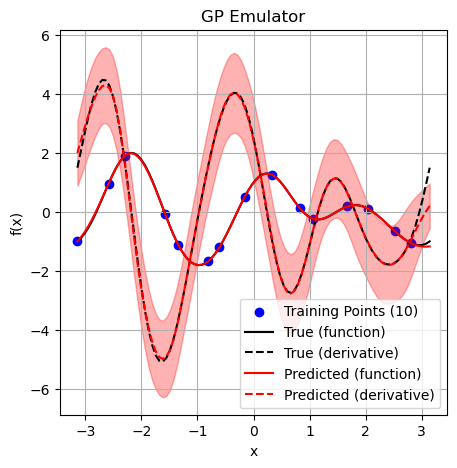

In [4]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x_train, y_train, color='blue', label='Training Points (10)')


ax.plot(grid_eval_grid, Z, color='black', label='True (function)')
ax.plot(grid_eval_grid, grad_eval, linestyle='--', color='black', label='True (derivative)')


ax.plot(grid_eval_grid, pred_mu, color='red', label='Predicted (function)')
ax.plot(grid_eval_grid, grad_pred, linestyle='--', color='red', label='Predicted (derivative)')
ax.fill_between(grid_eval_grid, (grad_pred - grad_pred_var)[:,0], 
                                (grad_pred + grad_pred_var)[:,0], color='red', alpha=0.3)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('GP Emulator')

plt.legend()
plt.grid()
plt.show()

### DGP Emulator

In [5]:
from dgpsi import dgp, kernel, combine, emulator, grad_lgp
import matplotlib.pyplot as plt
import numpy as np

In [6]:
y_train = np.array(test_f(x_train))
layer1=[kernel(length=np.array([1]),name='matern2.5', scale_est=True)]
layer2=[kernel(length=np.array([1]),name='matern2.5', scale_est=True)]
all_layer=combine(layer1,layer2)
m=dgp(x_train,y_train,all_layer)
m.train(N=100)
final_layer_obj=m.estimate()
# nb_seed(256)
emu=emulator(final_layer_obj,N=1)

Iteration 100: Layer 2: 100%|██████████| 100/100 [00:00<00:00, 193.36it/s]


In [7]:
pred_mu, pred_var = emu.predict(grid_eval_grid[:,None], full_layer=True)

In [8]:

grad_pred = np.zeros((100, 1))
grad_pred_var = np.zeros((100, 1))
num_imp = len(emu.all_layer_set)
for i in range(num_imp):
    tmp_grad_pred , tmp_grad_pred_var= grad_lgp(grid_eval_grid[:,None], emu.all_layer_set[i])
    grad_pred += tmp_grad_pred/num_imp
    grad_pred_var += tmp_grad_pred_var[:,:,0]/num_imp
# mu_first_layer, dmu_dx, _, _ = grad_lgp(grid_eval_grid[:,None], emu.all_layer_set[0])

nabla_r_1 = matern_k_one_vector_derivative(grid_eval_grid[:,None], 
                                           emu.all_layer_set[0][0][0].input,
                                           emu.all_layer_set[0][0][0].length, 1) 
nabla_r_1 = np.transpose(nabla_r_1, (0,2,1))
dmu1_dx = np.einsum('mdn,n->md', nabla_r_1, emu.all_layer_set[0][0][0].Rinv_y)



# pred_mu1, _ = emu.predict(grid_eval_grid[:,None], full_layer=True)
pred_mu1, _ = gp_pred(grid_eval_grid[:,None], 
                      emu.all_layer_set[0][0][0].input,
                      Rinv=emu.all_layer_set[0][0][0].Rinv, 
                      Rinv_y=emu.all_layer_set[0][0][0].Rinv_y,
                      length=emu.all_layer_set[0][0][0].length, 
                      scale=emu.all_layer_set[0][0][0].scale,
                      nugget=emu.all_layer_set[0][0][0].nugget,
                      name=emu.all_layer_set[0][0][0].name)

nabla_r_2 = matern_k_one_vector_derivative(pred_mu1[:,None],
                                           emu.all_layer_set[0][1][0].input,
                                           emu.all_layer_set[0][1][0].length, 1)

nabla_r_2 = np.transpose(nabla_r_2, (0,2,1))
dmu2_dmu1 = np.einsum('mdn,n->md', nabla_r_2, emu.all_layer_set[0][1][0].Rinv_y)

grad_pred_test = np.einsum('mp,mpd->md', dmu2_dmu1, dmu1_dx[:,None,:])

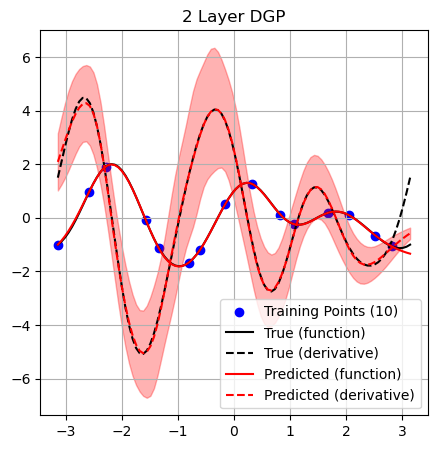

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(x_train, y_train, color='blue', label='Training Points (10)')


ax.plot(grid_eval_grid, Z, color='black', label='True (function)')
ax.plot(grid_eval_grid, grad_eval, linestyle='--', color='black', label='True (derivative)')


ax.plot(grid_eval_grid, pred_mu[1], color='red', label='Predicted (function)')
ax.plot(grid_eval_grid, grad_pred, linestyle='--', color='red', label='Predicted (derivative)')
# ax.plot(grid_eval_grid, grad_pred_test, linestyle='-.', color='red', label='Predicted (derivative) test')
ax.fill_between(grid_eval_grid, (grad_pred - grad_pred_var)[:,0],
                                (grad_pred + grad_pred_var)[:,0], color='red', alpha=0.3)
# ax.plot(grid_eval_grid, grad_pred+np.sqrt(grad_pred_var), color='green', linestyle='-.')
# ax.plot(grid_eval_grid, grad_pred-np.sqrt(grad_pred_var), color='green', linestyle='-.')
plt.title('2 Layer DGP')

plt.legend()
plt.grid()
plt.show()

## 2D Case

In [14]:
def finite_differecing(x_star, emulator, h=1e-6, num=3):
    assert len(x_star.shape) == 1
    assert num % 2 == 1, "num must be odd"
    D = x_star.shape[0]
    eval_grid = [np.linspace(x_star[i] - h, x_star[i] + h, num=num) for i in range(D)]
    eval_grid = np.meshgrid(*eval_grid)
    eval_grid = np.stack([eval_grid[i].flatten() for i in range(D)], axis=-1)
    pred_mu, _ = emulator.predict(eval_grid)
    pred_mu = pred_mu.reshape(num, num)
    grad = np.array(np.gradient(pred_mu, *([h] * D)))
    return grad[:, num // 2, num // 2]

In [10]:
# Define the benchmark function
def relu(x):
    return np.maximum(0, x)

def test_f(x):
    # make a little bit unstationary
    x1, x2 = x[..., 0], x[..., 1]
    # return 3*np.sin(x1) * np.cos(x2) + 12 * np.sin(2 * x1) * np.cos(3 * x2) 
    # return - (np.sin(x1)*np.sin(x1**2/np.pi)**m+np.sin(x2)*np.sin(2*x2**2/np.pi)**m)
    return np.sin(1/((0.7*x1+0.3)*(0.7*x2+0.3)))
# Define the closed-form gradient function
def gradient_test_f(x):
    x1, x2 = x[..., 0], x[..., 1]
    g = (0.7 * x1 + 0.3) * (0.7 * x2 + 0.3)  # Simplify the denominator term

    # Partial derivatives with respect to x1 and x2
    df_dx = - np.cos(1 / g) * (0.7 * (0.7 * x2 + 0.3)) / g**2
    df_dy = - np.cos(1 / g) * (0.7 * (0.7 * x1 + 0.3)) / g**2
    return np.array([df_dx, df_dy])

In [69]:
x1=np.array([0,.02,.075,.08,.14,.15,.155,.156,.18,.22,.29,.32,.36, .37,.42,.5,.57,.63,.72,.785,.8,.84,.925,1])
x2=np.array([.29,.02,.12,.58,.38,.87,.01,.12,.22,.08,.34,.185,.64, .02,.93,.15,.42,.71,1,0,.21,.5,.785,.21])
x_train = np.stack([x1, x2], axis=-1)

# lhd = LatinHypercubeDesign([(0, 1), (0, 1)])
# x_train = lhd.sample(64)
y_train = np.array(test_f(x_train))

# GP emulator
gp_emu = gp(x_train, y_train[:,None], kernel(length=np.array([1]), name='sexp', scale_est=True))
gp_emu.train()


# DGP emulator
# x_train = lhd.sample(64)
layer1=[kernel(length=np.array([1]),name='sexp', scale_est=True),
        kernel(length=np.array([1]),name='sexp', scale_est=True)]
layer2=[kernel(length=np.array([1]),name='sexp', scale_est=True)]
all_layer=combine(layer1,layer2)
m=dgp(x_train,y_train[:,None],all_layer)
m.train(N=500)
final_layer_obj=m.estimate()
emu=emulator(final_layer_obj,N=50)
# gp_emu = gp(x_train, y_train, kernel(length=np.array([1]), name='sexp', scale_est=True))
# gp_emu.train()
grid_eval_func = np.linspace(0, 1, 50)
grid_eval_func = np.meshgrid(grid_eval_func, grid_eval_func)
grid_eval_func = np.stack([grid_eval_func[0].flatten(), grid_eval_func[1].flatten()], axis=-1)
Z = test_f(grid_eval_func)  
pred_mu_gp, _ = gp_emu.predict(grid_eval_func)
pred_mu, _ = emu.predict(grid_eval_func)

Iteration 500: Layer 2: 100%|██████████| 500/500 [00:04<00:00, 112.56it/s]


In [70]:
grid_eval_grid = np.linspace(0.1, 0.9, 9)
grid_eval_grid = np.meshgrid(grid_eval_grid, grid_eval_grid)
grid_eval_grid = np.stack([grid_eval_grid[0].flatten(), grid_eval_grid[1].flatten()], axis=-1)
grad_eval = gradient_test_f(grid_eval_grid)

In [71]:
import time
start = time.time()
nabla_r = sexp_k_one_vector_derivative(grid_eval_grid, x_train, 
                                       gp_emu.kernel.length, 1)
grad_pred_gp = np.einsum('mnd,n->md', nabla_r, gp_emu.kernel.Rinv_y)
end = time.time()
gp_time = end - start


start_time = time.time()
grad_pred = np.zeros((81, 2))
grad_pred_var = np.zeros((81, 2, 2))
num_imp = len(emu.all_layer_set)
for i in range(num_imp):
    tmp_grad_pred, tmp_grad_pred_var = grad_lgp(grid_eval_grid, emu.all_layer_set[i])
    grad_pred += tmp_grad_pred/num_imp
    grad_pred_var += tmp_grad_pred_var/num_imp
end_time = time.time()
our_method_time = end_time - start_time


start_time = time.time()
grad_pred_ad = np.zeros((81, 2))
for j in range(num_imp):
    grad_pred_ad += vmap_grad_single_imp(grid_eval_grid, emu.all_layer_set[i])/num_imp
end_time = time.time()
ad_time = end_time - start_time

start_time = time.time()
grad_pred_finite_diff = np.array([finite_differecing(grid_eval_grid[i], emu) for i in range(81)])
end = time.time()
fd_time = end - start_time

In [72]:
our_method_time, gp_time, ad_time, fd_time

(0.13072896003723145,
 0.0003349781036376953,
 1.3993220329284668,
 1.6658661365509033)

In [73]:
# our method error 
grad_eval = grad_eval.T
error = np.linalg.norm(grad_pred - grad_eval, axis=-1)/np.linalg.norm(grad_eval, axis=-1)
error_gp = np.linalg.norm(grad_pred_gp - grad_eval, axis=-1)/np.linalg.norm(grad_eval, axis=-1)
error_ad = np.linalg.norm(grad_pred_ad - grad_eval, axis=-1)/np.linalg.norm(grad_eval, axis=-1)
error_finite_diff = np.linalg.norm(grad_pred_finite_diff - grad_eval, axis=-1)/np.linalg.norm(grad_eval, axis=-1)

In [ ]:
import numpy as np

def cosine_similarity(true_gradient:np.array, predicted_gradient:np.array) -> float:
    """
    Computes the cosine similarity between the true gradient and the predicted gradient.
    
    Parameters:
        true_gradient (array-like): The true gradient vector.
        predicted_gradient (array-like): The predicted gradient vector.
        
    Returns:
        float: Cosine similarity value between -1 (opposite) and 1 (identical).
    """
    assert len(true_gradient.shape) == 2
    assert len(predicted_gradient.shape) == 2
    assert true_gradient.shape == predicted_gradient.shape


    # Compute the dot product and magnitudes
    dot_product = np.sum(true_gradient * predicted_gradient, axis=-1)
    norm_true = np.linalg.norm(true_gradient, axis=-1)
    norm_predicted = np.linalg.norm(predicted_gradient, axis=-1)
    
    # Handle zero vector cases to prevent division by zero
    if norm_true == 0 or norm_predicted == 0:
        return 0.0  # Define similarity as 0 when one vector is zero
    
    # Compute cosine similarity
    cosine_sim = dot_product / (norm_true * norm_predicted)
    return cosine_sim


# def remove_outlier(data, threshold=5):
#     z_scores = zscore(data)
#     return data[np.abs(z_scores) < threshold]

def remove_outlier(data, quantile=0.9):
    return data[data < np.quantile(data, quantile)]

error = remove_outlier(error)
error_gp = remove_outlier(error_gp)
error_ad = remove_outlier(error_ad)
error_finite_diff = remove_outlier(error_finite_diff)


cos_sim_gp = vec_cos_sim(grad_eval, grad_pred_gp)
cos_sim = vec_cos_sim(grad_eval, grad_pred)
cos_sim_ad = vec_cos_sim(grad_eval, grad_pred_ad)
cos_sim_finite_diff = vec_cos_sim(grad_eval, grad_pred_finite_diff)

error.mean(), error_gp.mean(), error_ad.mean(), error_finite_diff.mean()

()


AttributeError: 'float' object has no attribute 'shape'

In [84]:
cos_sim

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [-1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [-1.,  1.],
       [-1., -1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [-1., -1.],
       [-1.,

(array([15., 43.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  2.,  0.,  1.,  2.]),
 array([ 0.055228  ,  0.55739946,  1.05957091,  1.56174237,  2.06391382,
         2.56608528,  3.06825673,  3.57042819,  4.07259964,  4.5747711 ,
         5.07694255,  5.579114  ,  6.08128546,  6.58345691,  7.08562837,
         7.58779982,  8.08997128,  8.59214273,  9.09431419,  9.59648564,
        10.0986571 ]),
 <BarContainer object of 20 artists>)

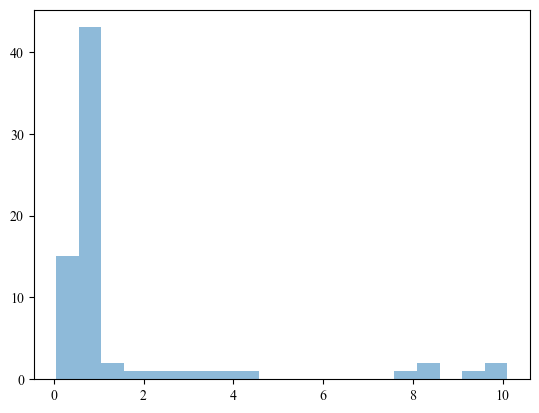

In [75]:
plt.hist(error_gp, bins=20, alpha=0.5, label='Our Method')

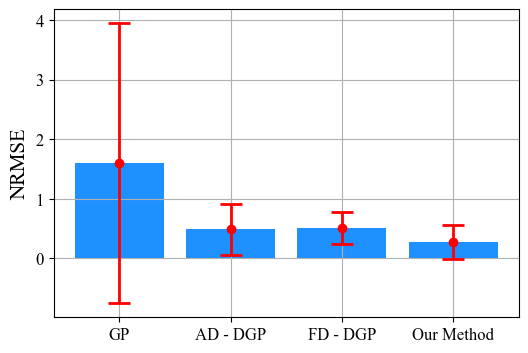

In [76]:
plt.figure(figsize=(6, 4), dpi=100)

plt.bar([ 'GP', 'AD - DGP', 'FD - DGP', 'Our Method'], 
        [error_gp.mean(), error_ad.mean(), error_finite_diff.mean(), error.mean()], color='dodgerblue')
#         [error.std(), error_gp.std(), error_ad.std(), error_finite_diff.std()])
        # [gp_time*15, ad_time, fd_time, our_method_time], color='orange')

plt.errorbar([ 'GP', 'AD - DGP', 'FD - DGP', 'Our Method'],
             [error_gp.mean(), error_ad.mean(), error_finite_diff.mean(), error.mean()],
             [ error_gp.std(), error_ad.std(), error_finite_diff.std(), error.std()], 
             fmt='o', color='red', capsize=8, capthick=2, linewidth=2)

# plt.ylabel('Computation Time (s)', fontsize=15)
plt.ylabel('NRMSE', fontsize=15)
plt.tick_params(axis='both', labelsize=12)
# plt.ylim(0, 1)
plt.grid()

In [28]:
from matplotlib import patches

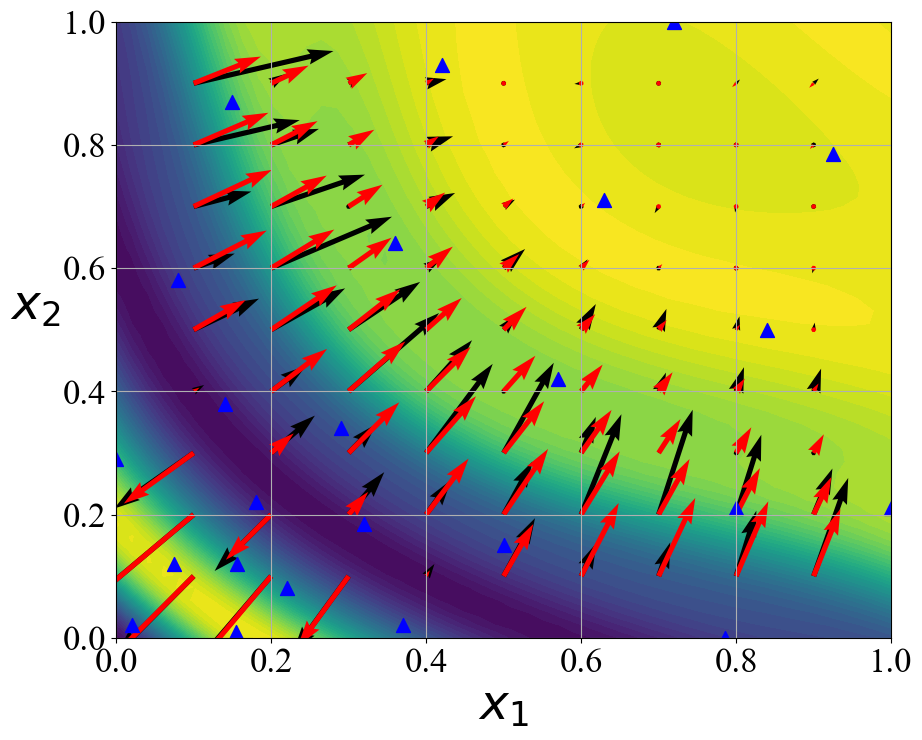

In [60]:
fig, ax = plt.subplots(figsize=(10, 8), dpi=100)
plt.rcParams.update({
                     'font.family':'Times New Roman',
                     })

# colorbar_1 = 
ax.contourf(grid_eval_func[:,0].reshape(50,50), 
                          grid_eval_func[:,1].reshape(50,50), 
                          # Z.reshape(50,50), levels=50)
                        # pred_mu_gp.reshape(50,50), levels=50)
                        pred_mu.reshape(50,50), levels=50)


ax.quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1],
          grad_pred[:, 0], grad_pred[:, 1], label='Predicted gradient')
# ax.quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1], 
# #           # grad_eval[0], grad_eval[1])
#             grad_pred_gp[:, 0], grad_pred_gp[:, 1], label='Predicted gradient')
          # grad_pred_finite_diff[:,0], grad_pred_finite_diff[:,1])
ax.quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1],
          grad_eval[0], grad_eval[1], color='red', label='True gradient')
          # grad_pred_ad[:,0], grad_pred_ad[:,1],label='Predicted gradient')
# ax.quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1],
#           grad_pred[:, 0], grad_pred[:, 1])



# ax.quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1],
#           grad_pred[:, 0], grad_pred[:, 1])



# draw elipse of uncertainty
# for i in range(81):
#     if np.nan in grad_pred_var[i]:
#         continue
#     elif np.all(grad_pred_var[i] > 1100):
#         continue
#     else:
#         plot_ellipse(grid_eval_grid[i], np.sqrt(grad_pred_var[i]), ax)
        # ax.add_patch(patches.Ellipse(grid_eval_grid[i], np.sqrt(grad_pred_var[i, 0])/100, np.sqrt(grad_pred_var[i, 1])/50, color='green', alpha=0.3))
    # ax.add_patch(plt.Circle(grid_eval_grid[i], np.sqrt(grad_pred_var[i, 0]), color='green', alpha=0.3))
    # ax.add_patch(plt.Circle(grid_eval_grid[i], np.sqrt(grad_pred_var[i, 1]), color='green', alpha=0.3))
    

# colorbar_1.set_clim(min_cbar, max_cbar)
# cbar = fig.colorbar(colorbar_1, 
#                     ax=ax, 
#                     # orientation='horizontal', 
#                     pad=0.025, 
#                     aspect=20)
# cbar.ax.tick_params(labelsize=20) 
# cbar.set_label('$f(x_1, x_2)$', fontsize=20, loc='top')
# ax.text(1.16, 1.04, '$\hat{f} (x_1, x_2)$', ha='center', va='center', fontsize=20, transform=ax.transAxes)
# ax[0].set_title("Test function", fontsize=15)
ax.set_xlabel(r"$x_1$", fontsize=35)
ax.set_ylabel(r"$x_2$", fontsize=35, rotation=0, labelpad=20)
ax.grid()
plt.tick_params(axis='both', which='major', labelsize=25)
# plt.tight_layout()
ax.scatter(x_train[:, 0], x_train[:, 1], color='blue', marker='^', s=100, label='Training points')



# plot_ellipse(grid_eval_grid[i], np.sqrt(grad_pred_var[i]), ax)
# plt.legend(fontsize=20, loc='upper right', bbox_to_anchor=(1.5, 1.5), ncol=4)
plt.show()


# colorbar_1 = ax[0].contourf(grid_eval_func[:,0].reshape(50,50), 
#                           grid_eval_func[:,1].reshape(50,50), 
#                           Z.reshape(50,50), levels=50)
# ax[1].quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1], grad_pred[:, 0], grad_pred[:, 1])
# colorbar_2 = ax[1].imshow(pred_mu.reshape(50, 50), extent=(0, 1, 0, 1))
# fig.colorbar(colorbar_2, ax=ax[1])
# ax[1].set_title("Emulator prediction", fontsize=15)
# ax[1].set_xlabel("x1", fontsize=12)
# ax[1].set_ylabel("x2", fontsize=12)
# ax[1].scatter(x_train[:, 0], x_train[:, 1], color='red', marker='x')
# ax[1].grid()

# ax[2].quiver(grid_eval_grid[:, 0], grid_eval_grid[:, 1], grad_pred_gp[:, 0], grad_pred_gp[:, 1])
# colorbar_3 = ax[2].imshow(pred_mu_gp.reshape(50, 50), extent=(0, 1, 0, 1))
# fig.colorbar(colorbar_3, ax=ax[2])
# ax[2].set_title("GP prediction", fontsize=15)
# ax[2].set_xlabel("x1", fontsize=12)
# ax[2].set_ylabel("x2", fontsize=12)
# ax[2].scatter(x_train[:, 0], x_train[:, 1], color='red', marker='x')
# ax[2].grid()


    
# plt.show()


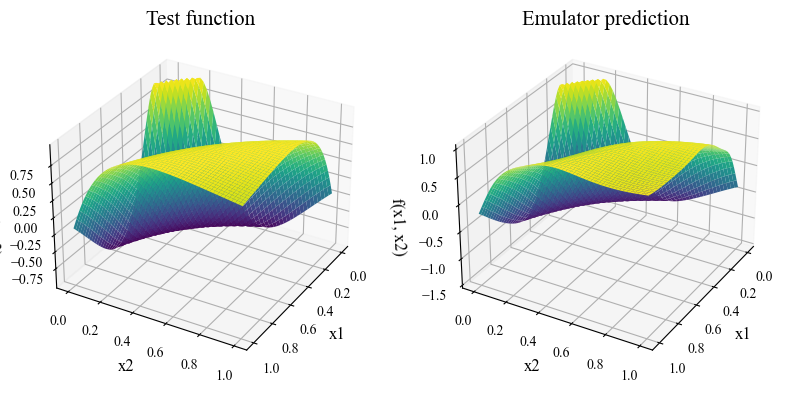

In [ ]:
# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=plt.figaspect(0.5))

# =============
# First subplot
# =============
# set up the Axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(grid_eval_func[:, 0].reshape(50, 50), grid_eval_func[:, 1].reshape(50, 50), Z.reshape(50, 50), cmap='viridis')
ax.set_title("Test function", fontsize=15)
ax.set_xlabel("x1", fontsize=12)
ax.set_ylabel("x2", fontsize=12)
ax.set_zlabel("f(x1, x2)", fontsize=12)
ax.view_init(30, 30)

# ==============
# Second subplot
# ==============
# set up the Axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(grid_eval_func[:, 0].reshape(50, 50), grid_eval_func[:, 1].reshape(50, 50), pred_mu.reshape(50, 50), cmap='viridis')
ax.set_title("Emulator prediction", fontsize=15)
ax.set_xlabel("x1", fontsize=12)
ax.set_ylabel("x2", fontsize=12)
ax.set_zlabel("f(x1, x2)", fontsize=12)
ax.view_init(30, 30)

plt.show()

In [ ]:
dgp_pred_finite_diff = np.array([finite_differecing(x, emu) for x in grid_eval_grid])

In [ ]:
dgp_pred_finite_diff.shape

(100, 2)

In [ ]:
gp_grad_error = np.linalg.norm(grad_eval.T - grad_pred_gp, axis=1)/np.linalg.norm(grad_eval.T, axis=1)
dgp_grad_error = np.linalg.norm(grad_eval.T - grad_pred, axis=1)/np.linalg.norm(grad_eval.T, axis=1)
finite_diff_error = np.linalg.norm(grad_eval.T - dgp_pred_finite_diff, axis=1)/np.linalg.norm(grad_eval.T, axis=1)

In [ ]:
np.mean(gp_grad_error[dgp_grad_error<1]), np.mean(dgp_grad_error[dgp_grad_error<1]), np.mean(finite_diff_error[dgp_grad_error<1])

(0.8494982643684408, 0.25540068977195646, 0.5544766444844657)

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Define the 2x2 covariance matrix
Sigma = np.array([[3, 1], [1, 2]])


def plot_ellipse(center, Sigma, ax, color='blue'):
    # Eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(Sigma)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]

    # Generate the ellipsoid (ellipse) points
    theta = np.linspace(0, 2 * np.pi, 100)
    circle = np.array([np.cos(theta), np.sin(theta)])

    # Scale and rotate the unit circle to create the ellipse
    ellipse = eigenvectors @ np.diag(np.sqrt(eigenvalues)) @ circle

    # Plot
    x = ellipse[0, :]/50 + center[0]
    y = ellipse[1, :]/50 + center[1]
    ax.plot(x, y, color=color, linestyle='--', label='Uncertainty ellipse (std)')
